# Test simple integrable models
E.g. harmonic oscillator, Kepler, Neumann

## Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfe = tf.contrib.eager
import sys
sys.path.append("../")

from IPython import display
import imageio
import glob
import os

In [67]:
from models import SymplecticExchange, SqueezeAndShift, Chain, MLP, AngleInvariantFlow, LinearSymplectic, HamiltonianFlow
from models import IdFlow, Permute, AffineCoupling, AdditiveCoupling, OscillatorFlow, ConstantShiftAndScale, MLPHamiltonian
from hamiltonians import single_harmonic_oscillator, kepler, parameterized_neumann
from utils import join_q_p, BaseDistributionNormal, BaseDistributionActionAngle, BaseDistributionIntegralsOfMotion
from utils import visualize_chain_bijector_1d

In [68]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()

In [61]:
tf.reset_default_graph()

In [69]:
tf.set_random_seed(0)

In [70]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [71]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': single_harmonic_oscillator,  #parameterized_neumann([.1,.2,.3]),
    'd': 1,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 512,    # Mini batch size 
    'num_bijectors': 6,   # Number of bijectors
    'train_iters': int(1e6)}   # Number of training iterations

Base distribution:

In [72]:
#base_dist = BaseDistributionActionAngle(settings)
#base_dist = BaseDistributionActionAngle(settings, action_dist='normal')
#base_dist = BaseDistributionNormal(settings)
base_dist = BaseDistributionIntegralsOfMotion(settings)

Define the model as sequence of a symplectic transformation T and a normalizing flow F. The Hamiltonian given by the log density of the transformed base distribution under F, should be soluble. 

Note: if using the symplectic exchange that has period 4, we should use multiple of 8 bijectors to have T to represent the identity at zero weights.

In [52]:
## Use this for action angle distribution
# T = Chain([OscillatorFlow()] + 
#           [SqueezeAndShift(shift_model=MLP()) if i % 2 == 0 
#            else SymplecticExchange() 
#            for i in range(settings['num_bijectors'])])

## Use this for Integrals of motion distribution
sz = [settings['batch_size'], settings['d'], settings['num_particles'], 2]
# T = HamiltonianFlow( MLPHamiltonian() , sz , num_steps=1000 )
T = Chain([SqueezeAndShift(shift_model=MLP()) if i % 2 == 0 
           else LinearSymplectic() 
           for i in range(settings['num_bijectors'])])


## Use this for action angle distribution. 
# dim_to_split = 1; na = settings['d']//2; nb = settings['d'] - na
### Use real NVP, split along the d dimension.
# # F = Chain([AffineCoupling(MLP(activation=tf.nn.relu, mode="shift_and_scale"), dim_to_split, [na, nb], is_positive_shift=True),
# #            Permute(dim_to_split, [na, nb]),
# #            AffineCoupling(MLP(activation=tf.nn.relu, mode="shift_and_scale"), dim_to_split, [na, nb], is_positive_shift=True),
# #            Permute(dim_to_split, [na, nb])])
## Additive coupling.
# F = Chain([AdditiveCoupling(MLP(activation=tf.nn.relu, 
#                                 mode="shift", 
#                                 out_shape=[-1,na,settings['num_particles'],1]), #out_shape as xa. 
#                             dim_to_split, [na, nb], is_positive_shift=True),
#            Permute(dim_to_split, [na, nb]),
#            AdditiveCoupling(MLP(activation=tf.nn.relu, 
#                                 mode="shift", 
#                                 out_shape=[-1,na,settings['num_particles'],1]), 
#                             dim_to_split, [na, nb], is_positive_shift=True),
#            Permute(dim_to_split, [na, nb])])
# F = AngleInvariantFlow(F)

# Use this for integrals of motion distribution to make the range of the distribution a learnable parameter.
F = ConstantShiftAndScale()

# Recall: Chain(A,B) applies first A then B:
model = Chain([F, T])

# For performance boost if eager, compile
if tf.executing_eagerly():
    model.call = tf.contrib.eager.defun(model.call)

In [73]:
dim_to_split = 1; na = settings['d']//2; nb = settings['d'] - na
## Use real NVP, split along the d dimension.
model = Chain([AffineCoupling(MLP(activation=tf.nn.relu, mode="shift_and_scale"), dim_to_split, [na, nb], is_positive_shift=False),
           Permute(dim_to_split, [na, nb]),
           AffineCoupling(MLP(activation=tf.nn.relu, mode="shift_and_scale"), dim_to_split, [na, nb], is_positive_shift=False),
           Permute(dim_to_split, [na, nb])])

In [74]:
## Infinite dataset: each iteration, sample
# z_samples = base_dist.sample(settings['batch_size'])

## Fixed batch. Every iteration gets exactly the same data
z_samples = base_dist.sample(settings['batch_size'])
z_samples = tf.constant(sess.run(z_samples)) 

## tf.data.Dataset. Create infinite dataset by repeating and shuffling a finite number of samples
# Z = sess.run( base_dist.sample(settings['batch_size']) )
# dataset = tf.data.Dataset.from_tensor_slices(Z.astype(NP_DTYPE))
# # repeat the dataset indefinetely
# dataset = dataset.repeat() 
# # Shuffle data every epoch
# dataset = dataset.shuffle(buffer_size=Z.shape[0])
# dataset = dataset.prefetch(3 * settings['batch_size'])
# dataset = dataset.batch(settings['batch_size'])
# data_iterator = dataset.make_one_shot_iterator()
# z_samples = data_iterator.get_next()

In [75]:
sess.run(tf.global_variables_initializer())

In [82]:
loss = tf.reduce_mean( settings['hamiltonian'](model(z_samples)) - model.log_jacobian_det(z_samples) )

In [83]:
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [78]:
sess.run(tf.global_variables_initializer())

In [86]:
sess.run(model.log_jacobian_det(z_samples))

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

### Visualize before training

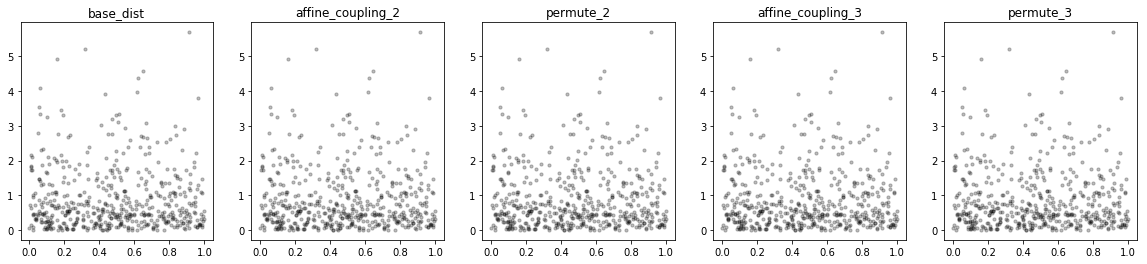

In [79]:
visualize_chain_bijector_1d(model, z_samples, sess=sess)

In [80]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)
#    fig = plt.figure(figsize=(4,4))
    fig = plt.figure()
    visualize_chain_bijector_1d(model, z_samples, sess=sess)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [81]:
global_step = []
np_losses = []
for i in range(int(settings['train_iters'])):
    _, np_loss = sess.run([train_op, loss])
    if i % 100 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % 100 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(model,
                                 i + 1,
                                 z_samples)
        print("Iteration: {}, loss = {}".format(i, np_loss))

start = 0
plt.plot(np_losses[start:])

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

### Create a GIF of the saved images

In [11]:
name = settings['hamiltonian'].__name__+'.gif'

In [12]:
with imageio.get_writer(name, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp '+name+' '+name+'.png')

0

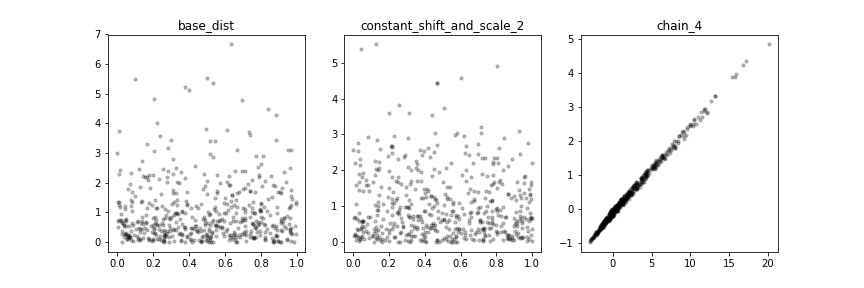

In [13]:
display.Image(filename=name+'.png')

In [29]:
# Test accuracy
# z_samples = base_dist.sample(settings['batch_size'])
# test_error = compute_loss(model, settings['hamiltonian'], z_samples)
# print("Test error: ", test_error)

### Visualize after training

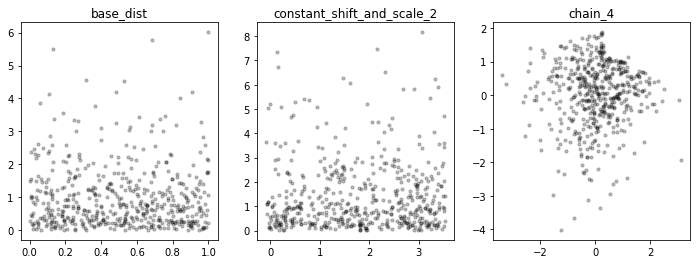

In [72]:
visualize_chain_bijector_1d(model, z_samples, sess=sess)

## System flow

In [21]:
T = model.bijectors[1]
#f = model.bijectors[0]._flow
f = model.bijectors[0]

In [22]:
import importlib
import utils
importlib.reload(utils)
from utils import system_flow

In [29]:
q0 = tf.constant([1.], shape=[1,settings['d'], settings['num_particles'], 1])
p0 = tf.constant([0.], shape=[1,settings['d'], settings['num_particles'], 1])
ts = tf.range(0,10,delta=.1, dtype=DTYPE)
qs, ps, omega = system_flow(q0, p0, T, f, ts, prior='integrals_of_motion')

In [17]:
#print("frequencies: ", sess.run(omega))

In [31]:
qq = sess.run(qs)
pp = sess.run(ps)

In [14]:
#plt.plot(qq[:,0,0,0],pp[:,0,0,0])
#plt.plot(qq[:,1,0,0],pp[:,1,0,0])
#plt.plot(qq[:,2,0,0],pp[:,2,0,0])

In [34]:
xs = join_q_p(qs,ps)

In [35]:
hs = settings['hamiltonian'](xs)

In [36]:
hh = sess.run(hs)

In [15]:
#plt.plot(hh)

In [16]:
#qsqr = tf.reduce_sum(tf.square(qs),[1,2,3])
#qsqr_val = sess.run(qsqr)
#plt.plot(qsqr_val)